<a href="https://colab.research.google.com/github/guiOsorio/Learning_JAX/blob/master/Framework_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit, vmap, grad, value_and_grad
from jax import random
import jax

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import time
import matplotlib.pyplot as plt
import pandas as pd

### Train basic PyTorch model

In [ ]:
class CustomTensorDataset(Dataset):
  def __init__(self, dataset):
    [data_X, data_y] = dataset
    X_tensor, y_tensor = data_X, data_y
    tensors = (X_tensor, y_tensor)
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors

  def __getitem__(self, index):
    x = self.tensors[0][index]

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

In [ ]:
train_x = torch.tensor([
    [2.7810836,2.550537003],
    [1.465489372,2.362125076],
    [3.396561688,4.400293529],
    [1.38807019,1.850220317],
    [3.06407232,3.005305973],
    [7.627531214,2.759262235],
    [5.332441248,2.088626775],
    [6.922596716,1.77106367],
    [8.675418651,-0.242068655],
    [7.673756466,3.508563011]
])

train_y = torch.tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

train_x.shape,train_y.shape

(torch.Size([10, 2]), torch.Size([10]))

In [ ]:
# Define model variables
input_size = train_x.size()[1]
hidden_size = 1 # number of neurons in hidden layer
output_size = 2 # binary = 2 possible solutions

model = nn.Sequential(nn.Linear(input_size, hidden_size)
                      ,nn.Sigmoid()
                      ,nn.Linear(hidden_size, output_size))
                      # ,nn.Sigmoid()) #why does adding sigmoid mess up the output?

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=1, out_features=2, bias=True)
)

In [ ]:
train = [train_x, train_y]
train_dset = CustomTensorDataset(train)
dataloader = DataLoader(train_dset, shuffle=True, num_workers=2)
# Define variables for training
loss = nn.MSELoss() # mean squared error
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
losses = []
start = time.time()

# Train PyTorch model
for epoch in range(100):
  running_loss = 0
  for data in dataloader:
    x, y = data
    optimizer.zero_grad() # reset gradients
    loss_val = loss(model(x), y) # calculate loss
    loss_val.backward() # calculate gradients
    optimizer.step() # update weights
    running_loss += loss_val.item()
  losses.append(running_loss)
end = time.time()

print(end-start)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


18.41679811477661


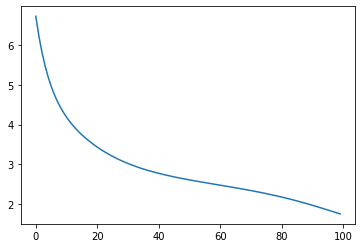

In [ ]:
plt.plot(losses)

### Test PyTorch model on credit card dataset, keep track of time of training and prediction

In [ ]:
# Load data
url = 'https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv'
df = pd.read_csv(url)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Divide into features and labels
df_x2 = df.iloc[:, 1:4]
df_y2 = df['Class'].to_frame()

total_points = df_y2.shape[0]
split = round(total_points*0.6)

# Convert to tensors
train_x2 = torch.tensor(df_x2.values, dtype=torch.float32)[:split]
train_y2 = torch.tensor(df_y2.values, dtype=torch.float32)[:split]

test_x2 = torch.tensor(df_x2.values, dtype=torch.float32)[split:]
test_y2 = torch.tensor(df_y2.values, dtype=torch.float32)[split:]

train_x2.size(), train_y2.size(), test_x2.size(), test_y2.size()

(torch.Size([170884, 3]),
 torch.Size([170884, 1]),
 torch.Size([113923, 3]),
 torch.Size([113923, 1]))

In [ ]:
# Define same model as the previous time
input_size2 = train_x2.size()[1]
hidden_size2 = 10 # number of neurons in hidden layer
output_size2 = 1

model2 = nn.Sequential(nn.Linear(input_size2, hidden_size2)
                      ,nn.Sigmoid()
                      ,nn.Linear(hidden_size2, output_size2)
                      ,nn.Sigmoid()) #why does adding sigmoid mess up the output?

model2

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
train2 = [train_x2, train_y2]
train_dset2 = CustomTensorDataset(train2)
dataloader2 = DataLoader(train_dset2, batch_size=100, shuffle=True)

# Define variables for training
loss2 = nn.MSELoss() # mean squared error
optimizer2 = optim.SGD(model2.parameters(), lr=0.2)

In [ ]:
losses2 = []
start2 = time.time()

# Train PyTorch model
for epoch in range(10):
  running_loss = 0
  for data in dataloader2:
    x, y = data
    optimizer2.zero_grad() # reset gradients
    loss_val = loss2(model2(x), y) # calculate loss
    loss_val.backward() # calculate gradients
    optimizer2.step() # update weights
    running_loss += loss_val.item()
  losses2.append(running_loss)
end2 = time.time()

print(end2-start2)

20.641268253326416


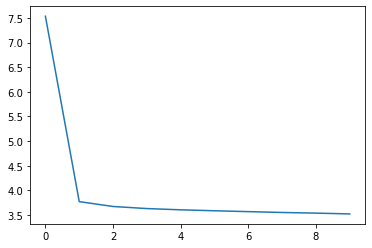

In [ ]:
plt.plot(losses2)

In [ ]:
# Predict on test set
correct = 0
total = test_y2.size()[0]
for features, label in zip(test_x2, test_y2):
    pred = 0 if model2(features).item() < 0.5 else 1
    l = label.item()
    if pred == l:
      correct += 1
accuracy = correct / total
print(accuracy)

0.9988413226477533


## PyTorch model times
##### With no hardware accelerator:
- Model 1 (100 epochs, num_workers=2) -> **8.6883 s**
- Model 2 (10 epochs, batch_size=100, num_workers=10) -> 

##### With GPU hardware accelerator:
- Model 1 (100 epochs, num_workers=2) -> **7.9927 s**
- Model 2 (10 epochs, batch_size=100, num_workers=10)
  - **4.8472 s**
  - **accuracy of 99.35%**
- Model 2 (10 epochs, num_workers = 10) 
  - **179.3489 s** 
  - **accuracy of 99.55%**
- Model 2 (10 epochs)
  - **37.5481 s**
  - **accuracy of 99.6%**

Results are expected using the first 10000 data points of the original data with 3 features, with an 80/20 train test split.

## Final Model

- Model 2 on entire dataset with 60/40 split & batch_size=100
  - **17.4195 s**
  - **accuracy of 99.88%**

Further exploration questions/todos:
-  why does sigmoid activation in output layer not work on model 1?
- what does num_workers do? (note how training of model was faster without workers)
- any particular advantages to using nn.Sequential vs nn.Module?
- GPU vs TPU, when is it best to use each
- do a classification matrix on final model for evaluation
- create JAX neural net for Titanic dataset and submit, note accuracy in test set


### Build same model with JAX on credit card dataset - keep track of time of training and prediction and compare to PyTorch's model

In [ ]:
# Initialize parameters of the model
seed = 0

def init_params(layers_size, parent_key):

  params = []
  # From a parent key, generate different keys for each layer
  keys = jax.random.split(parent_key, num=len(layers_size)-1) # understand better what split does/why is it useful

  # Set sizes of layers in the model (inputs to layers and outputs to layers)
  in_layers = layers_size[:-1]
  out_of_layers = layers_size[1:]

  for in_layer, out_of_layer, key in zip(in_layers, out_of_layers, keys):
    weights_key, bias_key = jax.random.split(key)

    # Initialize params to be an array [weights, bias]
    #where the weights are n rows (number of neurons, outputs to layer, inputs to next layer) x m columns (number of inputs to layer, outputs from previous layer/features)
    #bias are n rows x 1 column (one bias per neuron)
    params.append([
        0.1*jax.random.normal(weights_key, shape=(out_of_layer, in_layer)) # n x m matrix
        ,0.1*jax.random.normal(bias_key, shape=(out_of_layer,)) # vector with n values
    ])

  return params
key3 = jax.random.PRNGKey(seed)
params3 = init_params([3,10,1], key3)

# Go through each layer of the initialized params and check if the shape is the expected one
jax.tree_map(lambda x: x.shape, params3)

[[(10, 3), (10,)], [(1, 10), (1,)]]

In [ ]:
# Create a function to predict using the initialized neural net
def predict(params, x):
  hiddens = params[:-1] # take all hidden layers of the model (only one in our case)
  
  # Create a variable that will forward through the network (except the final layer) and store its output, based on an initial input
  output_x = x
  # Forward pass of x into the hidden layers
  for w, b in hiddens:
    output_x = jax.nn.sigmoid(jnp.dot(w, output_x) + b)
  # at the end of this for loop, we have the inputs to the final layer of the network

  # Forward pass output layer 
  #(done separately because often the final activation is different. if activation is the same, this operation can be implemented in the for loop above)
  ws_last, b_last = params[-1]
  final_output = jnp.dot(ws_last, output_x) + b_last

  return final_output

print(predict(params3, train_x2[0].numpy()))

batched_predict = vmap(predict, in_axes=(None, 0))

print(batched_predict(params3, train_x2[0:2].numpy()))

[0.06454311]
[[0.06454311]
 [0.06740828]]


In [ ]:
def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.stack(transposed_data[1])
    features = np.stack(transposed_data[0])

    return features, labels

In [ ]:
batch_size = 100
# Create train and test dataloaders
train_dl3 = DataLoader(train_dset2, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=True)

test3 = [test_x2, test_y2] # same data as in last model
test_dset3 = CustomTensorDataset(test3)
test_dl3 = DataLoader(test_dset3, batch_size=batch_size, collate_fn=custom_collate_fn, shuffle=False)

# Print shapes of each batch to see if it matches up with the expected shapes based on our batch size
for x, y in train_dl3:
  print(x.shape)
  print(y.shape)
  break
print('----')
for x, y in test_dl3:
  print(x.shape)
  print(y.shape)
  break

(100, 3)
(100, 1)
----
(100, 3)
(100, 1)


In [ ]:
# Loss function
def loss_fn(params, features, labels):
  
  preds = batched_predict(params, features)
  err = jnp.abs(preds - labels)

  return jnp.mean(jnp.square(err)) # MSE

for fs, lbls in test_dl3:
  print(loss_fn(params3, fs, lbls))
  break

0.0039056754


In [ ]:
# Update function
@jit # jit causes the function inputs to change type
def update(params, features, labels, lr=0.2):
  loss, grads = value_and_grad(loss_fn)(params, features, labels)

  return loss, jax.tree_map(lambda p, g: p - lr*g, params, grads)

In [ ]:
# Accuracy function
def accuracy(params, test_dl):
  # Return accuracy of model's (params3) predictions based on test dataloader
  wrong_count = 0
  # i = 0
  for x, y in test_dl:
    preds = batched_predict(params, x)
    wrong_count += jnp.sum(jnp.abs((preds > 0.5) - y))

    # i += 1
    # if i == 1000:
    #   break
  return 1 - (wrong_count / len(test_dl))

accuracy(params3, test_dl3)

DeviceArray(0.8842105, dtype=float32)

In [ ]:
# Train model
n_epochs = 10

for epoch in range(n_epochs):
  running_loss = 0
  for i, (features, labels) in enumerate(train_dl3):

    loss, params3 = update(params3, features, labels)
    running_loss += loss
    # if i % 100 == 0:
    #   print(loss)
    
  print(f'Epoch {epoch}, test acc = {accuracy(params3, test_dl3)}, running loss = {running_loss}')
  # print(params3)

Epoch 0, test acc = 0.8842105269432068, running loss = 3.428154706954956
Epoch 1, test acc = 0.8842105269432068, running loss = 3.332705497741699
Epoch 2, test acc = 0.8842105269432068, running loss = 3.279425621032715
Epoch 3, test acc = 0.8842105269432068, running loss = 3.1570122241973877
Epoch 4, test acc = 0.8842105269432068, running loss = 3.0330605506896973
Epoch 5, test acc = 0.8842105269432068, running loss = 2.9695558547973633
Epoch 6, test acc = 0.8842105269432068, running loss = 2.9159111976623535
Epoch 7, test acc = 0.8842105269432068, running loss = 2.8683111667633057
Epoch 8, test acc = 0.8842105269432068, running loss = 2.8470637798309326
Epoch 9, test acc = 0.8842105269432068, running loss = 2.8150129318237305


### Build JAX model for Titanic dataset